In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# get the data
import pods, pandas as pd
data = pods.datasets.singlecell()
genes = data['Y']
labels = data['labels']
label_dict = dict(((i,l) for i,l in enumerate(labels)))
#print label_dict
N = genes.shape[0]
G = genes.shape[1]
genes.describe()
print genes.shape
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1

(437, 48)


In [3]:
# generate label legend
labelLegend = np.unique(labels)
v = np.zeros_like(labels)
for i,l in enumerate(labelLegend):
    idx = np.flatnonzero(labels==l)
    v[idx] = i

In [4]:
import cPickle as pickle
# From manifold load pseudotime, Y and labels
dictData = pickle.load( open( "data/guo_ssData.p", "rb" ) )
ptFull = dictData['pt']
print ptFull.shape


(437,)


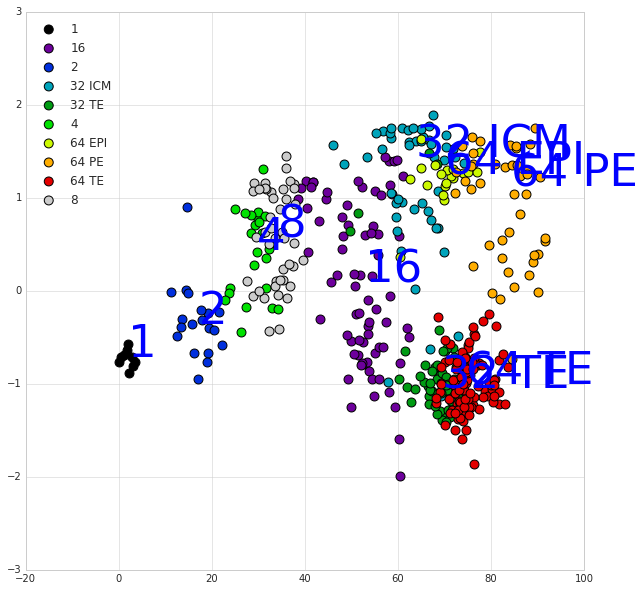

In [5]:
def plotGene(t,g):
    import matplotlib.cm as cm
    with plt.style.context('seaborn-whitegrid'):
        colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
        plt.figure(figsize=(10, 10))
        for lab,c in zip(labelLegend,colors):
            y1 = t[labels == lab]
            y2 = g[labels == lab]
            plt.scatter(y1,y2,label=lab, c=c,s=80)
            plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
        plt.legend(loc='upper left')
plotGene(ptFull, genes.Id2)

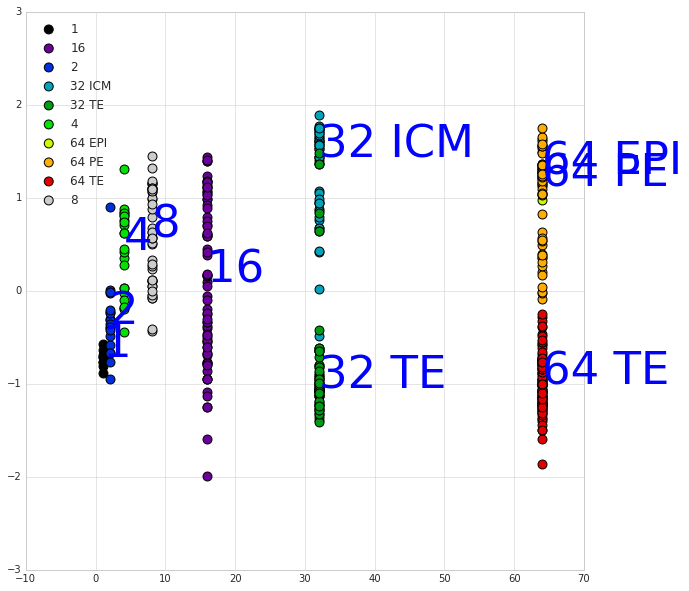

In [6]:
plotGene(stageCell, genes.Id2)

In [7]:
import GPflow

In [125]:
class SinKernel(GPflow.kernels.Kern):
    def __init__(self, input_dim, period=1.0, variance=1.0, lengthscales=None, active_dims=None, ARD=False):
        assert input_dim == 1, 'dims > 1 not supported yet'
        assert ARD == False
        
        GPflow.kernels.Kern.__init__(self, input_dim, active_dims)
        self.variance = GPflow.param.Param(variance, GPflow.transforms.positive)
        if lengthscales is None:
            lengthscales = 1.0
        self.lengthscales = GPflow.param.Param(lengthscales, GPflow.transforms.positive)
        self.ARD = False
        self.period = GPflow.param.Param(period, GPflow.transforms.positive)
        
    def Kdiag(self, X):
        zeros = X[:,0]*0 
        return zeros + self.variance
    
    def K(self, X, X2=None):
        X, X2 = self._slice(X, X2)
        
        if X2 is None:
            # this uses broadcasting to get NXN matrix
            rd =  tf.reshape(X, (-1,1)) - tf.reshape(X, (1,-1))
        else:
            rd =  tf.reshape(X, (-1,1)) - tf.reshape(X2, (1,-1))
        
        r = tf.sin(np.pi * rd  / self.period)
        rl = r / self.lengthscales
        
        return self.variance * tf.exp(-tf.square(r)/2)            

In [150]:
T0 = np.linspace(-1,1,10)[:,None]

import GPy
kper = GPy.kern.StdPeriodic(1)
Kgpy = kper.K(T0)
print Kgpy
print Kgpy.shape

[[ 1.          0.81335472  0.61574451  0.68728928  0.94318872  0.94318872
   0.68728928  0.61574451  0.81335472  1.        ]
 [ 0.81335472  1.          0.81335472  0.61574451  0.68728928  0.94318872
   0.94318872  0.68728928  0.61574451  0.81335472]
 [ 0.61574451  0.81335472  1.          0.81335472  0.61574451  0.68728928
   0.94318872  0.94318872  0.68728928  0.61574451]
 [ 0.68728928  0.61574451  0.81335472  1.          0.81335472  0.61574451
   0.68728928  0.94318872  0.94318872  0.68728928]
 [ 0.94318872  0.68728928  0.61574451  0.81335472  1.          0.81335472
   0.61574451  0.68728928  0.94318872  0.94318872]
 [ 0.94318872  0.94318872  0.68728928  0.61574451  0.81335472  1.
   0.81335472  0.61574451  0.68728928  0.94318872]
 [ 0.68728928  0.94318872  0.94318872  0.68728928  0.61574451  0.81335472
   1.          0.81335472  0.61574451  0.68728928]
 [ 0.61574451  0.68728928  0.94318872  0.94318872  0.68728928  0.61574451
   0.81335472  1.          0.81335472  0.61574451]
 [ 0.813

In [151]:
kperGPFlow = SinKernel(1)
D = T0.shape[1]
Xs = tf.placeholder("float64", shape=[None, D])
Ys = tf.placeholder("float64", shape=[None, D])
parameterVector = tf.placeholder("float64") # Needed by GPflow

with kperGPFlow.tf_mode():
    kperGPFlow.make_tf_array(parameterVector)
    kperGPFlow_s = kperGPFlow.K(Xs,Ys)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())  # Not sure this is needed
    K = sess.run(kperGPFlow_s, feed_dict={parameterVector:kperGPFlow.get_free_state(), Xs:T0, Ys:T0.copy() })    
    
print K  
print K.shape
#np.linalg.cholesky(K)


[[ 1.          0.81335472  0.61574451  0.68728928  0.94318872  0.94318872
   0.68728928  0.61574451  0.81335472  1.        ]
 [ 0.81335472  0.61574451  0.68728928  0.94318872  0.94318872  0.68728928
   0.61574451  0.81335472  1.          0.81335472]
 [ 0.61574451  0.68728928  0.94318872  0.94318872  0.68728928  0.61574451
   0.81335472  1.          0.81335472  0.61574451]
 [ 0.68728928  0.94318872  0.94318872  0.68728928  0.61574451  0.81335472
   1.          0.81335472  0.61574451  0.68728928]
 [ 0.94318872  0.94318872  0.68728928  0.61574451  0.81335472  1.
   0.81335472  0.61574451  0.68728928  0.94318872]
 [ 0.94318872  0.68728928  0.61574451  0.81335472  1.          0.81335472
   0.61574451  0.68728928  0.94318872  0.94318872]
 [ 0.68728928  0.61574451  0.81335472  1.          0.81335472  0.61574451
   0.68728928  0.94318872  0.94318872  0.68728928]
 [ 0.61574451  0.81335472  1.          0.81335472  0.61574451  0.68728928
   0.94318872  0.94318872  0.68728928  0.61574451]
 [ 0.813

In [153]:
np.linalg.cholesky(Kgpy)

LinAlgError: Matrix is not positive definite

In [124]:
# Tensorflow
D = 1 # dimensionality, only used for checking dimensions, could skip
Xs = tf.placeholder("float64", shape=[None, D])
Ys = tf.placeholder("float64", shape=[None, D])
X2s = tf.reduce_sum(tf.square(Xs), 1)
Y2s = tf.reduce_sum(tf.square(Ys), 1)
qs =  -2*tf.matmul(Xs, tf.transpose(Ys)) + tf.reshape(X2s, (-1,1)) + tf.reshape(Y2s, (1,-1))    

ktf = None

T0 = np.linspace(1,5,5)[:,None]

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())  # Not sure this is needed
    K = sess.run(tf.square(Ys) ,feed_dict={Xs: T0, Ys: T0})
print K    
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())  # Not sure this is needed
    K = sess.run(tf.reduce_sum(tf.square(Ys), 1),feed_dict={Xs: T0, Ys: T0})
print K    

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())  # Not sure this is needed
    K = sess.run(tf.reshape(Xs, (-1,1)) + tf.reshape(Ys, (1,-1)),feed_dict={Xs: T0, Ys: T0})
print K   

[[  1.]
 [  4.]
 [  9.]
 [ 16.]
 [ 25.]]
[  1.   4.   9.  16.  25.]
[[  2.   3.   4.   5.   6.]
 [  3.   4.   5.   6.   7.]
 [  4.   5.   6.   7.   8.]
 [  5.   6.   7.   8.   9.]
 [  6.   7.   8.   9.  10.]]


In [ ]:
import GPflow
import tensorflow as tf


class Deep(GPflow.model.Model):
    def __init__(self, Y, k1, k2, T0, X0, mf1=None, mf2=None):
        GPflow.model.Model.__init__(self)
        self.k1 = k1
        self.k2 = k2
        self.T = GPflow.param.Param(T0)
        self.X = GPflow.param.Param(X0)
        self.Y = Y
        
        if mf1 is None:
            mf1 = GPflow.mean_functions.Zero()
        if mf2 is None:
            mf2 = GPflow.mean_functions.Zero()
        self.mf1, self.mf2 = mf1, mf2

    def build_likelihood(self):

        # p(X | T)
        self.K1 = self.k1.K(self.T)
        self.K2 = self.k2.K(self.X)
        self.L1 = tf.cholesky(self.K1)
        self.m1 = self.mf1(self.T)
        l = GPflow.densities.multivariate_normal(self.X, self.m1, self.L1)

        # p(Y | X)        
        self.L2 = tf.cholesky(self.K2)
        self.m2 = self.mf2(self.T)
        l += GPflow.densities.multivariate_normal(self.Y, self.m2, self.L2)

        return l

In [154]:
D = genes.shape[1]
Qx = 2
Qt = 1
#k1 = GPflow.kernels.RBF(Qt) # p(x|t)
k1 = SinKernel(1) +  GPflow.kernels.White(1)
k2 = GPflow.kernels.RBF(Qx) # p(y|x,t)
T0 = np.random.normal(size=(N,1))
#X0 = np.random.normal(size=(N,1))
X0 = np.random.multivariate_normal(np.zeros((Qx)), np.eye(Qx), size=(N))
m = Deep(Y=genes.values,k1=k1,k2=k2, T0=T0, X0=X0)

In [94]:
m.k1

Name,values,prior,constriant
k1.variance,[ 1.],None,+ve
k1.lengthscales,[ 1.],None,+ve
k1.period,[ 1.],None,+ve


In [133]:
with m.tf_mode():
    K = m._session.run(m.K1, feed_dict={m._free_vars:m.get_free_state()})
print K.shape
print np.allclose(K.T, K) # check symmetric
np.linalg.cholesky(K)


(437, 437)
True


LinAlgError: Matrix is not positive definite

In [155]:
m.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: inf
 hess_inv: <1317x1317 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
   status: 0
  success: True
        x: array([ 0.54132485,  0.54132485, -0.23458507, ...,  0.54132485,
        0.54132485,  0.54132485])

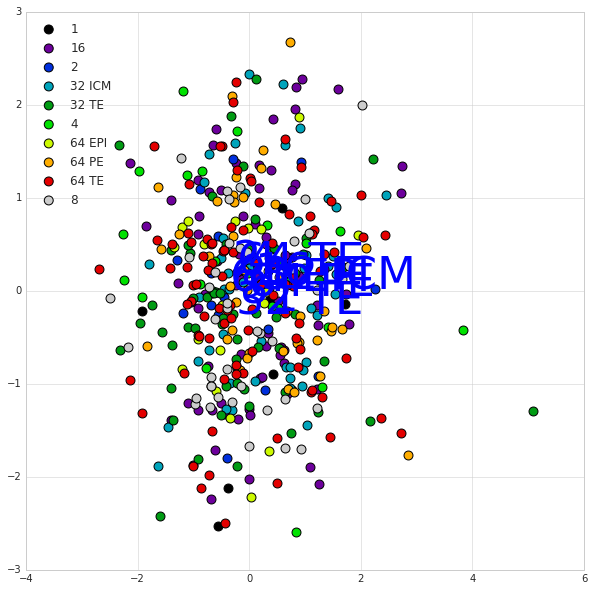

In [85]:
plotGene(m.T._array, m.X._array[:,1] )

In [38]:
m.X._array.shape

(437, 2)

In [39]:
m.T._array.shape

(437, 1)

In [28]:
X0.T.shape

(48, 1)